# Figure 2 Panels

In [1]:
experiment_ids = 'f1'
timepoints = 'all'
regions = 'cusanovich_dm6_peaks_1kb'
correction = 'wasp'

In [2]:
label = '_'.join([experiment_ids, timepoints, 'windows'])
wasp_corrected = True if correction == 'wasp' else False

## Imports

In [3]:
# general
import sys
import os

In [4]:
# tools
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
from scipy.stats import probplot

from dali.utils.stats import apply_fdr_bh

sc.settings.verbosity = 3

#path to R installation
os.environ['R_HOME'] = '/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/R' 

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri, Formula
from rpy2.robjects.conversion import localconverter

In [5]:
# plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib_venn as venn

In [6]:
# local
sys.path.append('..')
from utils import settings
from utils import dataloader

## Global variables

In [7]:
DALIHOM_PVAL = 'DALIHOM'
DALIHET_PVAL = 'DALIHET_VAE'
DALIHET_LINEAGE_PVAL = lambda x : 'DALIHET_TIME_%s' % x
DALIJOINT_PVAL = 'DALIJOINT'
DALIJOINT_RHO = 'DALIJOINT_RHO'

## Plot settings

In [8]:
%config InlineBackend.figure_format = 'retina'

plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 13
sns.set_style("ticks")

In [9]:
FIGURE_NUMBER = 2
PANEL_COUNTS = 1

def save_panel(fig):
    global PANEL_COUNTS
    
    fig_dir = 'figures/fig%d' % FIGURE_NUMBER
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    fig.savefig(fig_dir + '/panel_%d.svg' % PANEL_COUNTS, dpi=350)
    PANEL_COUNTS += 1

## Load processed anndata

In [10]:
adata_total = sc.read(os.path.join(settings.DATA_DIR, label, 'total_counts_vae_processed.h5ad'))

In [11]:
adatas_allelic = dict()
for exp_id in settings.F1_EXP_IDS:
    fname = '_'.join([exp_id, regions, correction, 'allelic_counts.h5ad'])
    adatas_allelic[exp_id] = sc.read(os.path.join(settings.DATA_DIR, label, fname))

In [12]:
LINEAGES = adata_total.obs['annotation'].cat.categories

LINEAGE_COLORS = dict(zip(
    LINEAGES,
    adata_total.uns['annotation_colors'].tolist()))
LINEAGE_COLORS['Other'] = 'gray'

In [13]:
adatas_allelic['SS148']

AnnData object with n_obs × n_vars = 10220 × 12861
    obs: 'timepoint', 'exp_id', 'time_vae', 'leiden_vae', 'lineage_muscle', 'lineage_nervous', 'annotation', 'n_peaks_by_counts', 'log1p_n_peaks_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_peaks', 'pct_counts_in_top_100_peaks', 'pct_counts_in_top_200_peaks', 'pct_counts_in_top_500_peaks'
    var: 'chr', 'start', 'end', 'length', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'count_variance', 'allelic_counts', 'mean_accessible', 'lineage_muscle_covered', 'lineage_nervous_covered', 'dalihet_vae', 'dalihet_leiden', 'dalihet_time', 'dalijoint', 'dalijoint_rho', 'lrt', 'dalihet_time_muscle', 'dalihet_time_nervous', 'BDGP_dist', 'BDGP_name', 'BDGP_terms', 'CAD_overlap', 'CAD_terms', 'DHS_peak', 'DN_peak', 'ELAV_peak', 'MEF_peak', 'TSS_1kb_peak', 'dalihet_time_muscle_bh', 'dalihet_time_nervous_bh', 'dalihet_vae_bh', 'dalihet_vae_ih

## Combine results and analyze

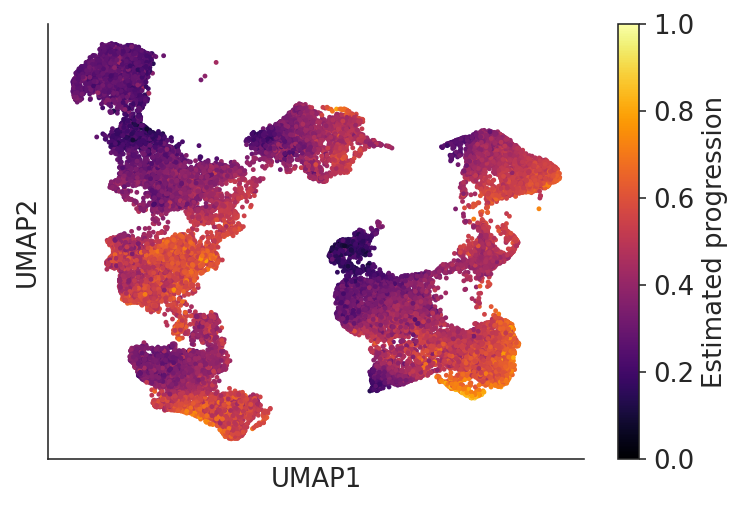

In [14]:
fig, ax = plt.subplots()
p = ax.scatter(
    adata_total.obsm['X_umap'][:, 0],
    adata_total.obsm['X_umap'][:, 1],
    c=adata_total.obs['time_vae'],
    cmap=plt.cm.inferno,
    s=2, rasterized=True)
ax.set_xticks([])
ax.set_yticks([])
ax.set(xlabel='UMAP1', ylabel='UMAP2')
plt.colorbar(p, label='Estimated progression')
sns.despine()
save_panel(fig)

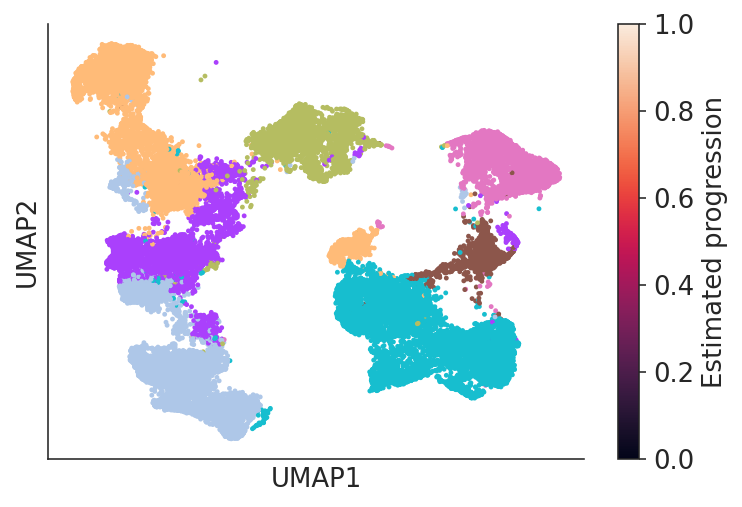

In [15]:
fig, ax = plt.subplots()
p = ax.scatter(
    adata_total.obsm['X_umap'][:, 0],
    adata_total.obsm['X_umap'][:, 1],
    c=adata_total.obs['annotation'].replace(LINEAGE_COLORS),
    s=2, rasterized=True)
ax.set_xticks([])
ax.set_yticks([])
ax.set(xlabel='UMAP1', ylabel='UMAP2')
plt.colorbar(p, label='Estimated progression')
sns.despine()
save_panel(fig)

In [16]:
# extract p-values for all crosses
df_all = pd.DataFrame()
for exp_id, adata in adatas_allelic.items():
    cols = [
        DALIHET_PVAL, 
        DALIJOINT_PVAL, 
        DALIHOM_PVAL]
    cols += [c + '_bh' for c in cols]
    cols += [DALIJOINT_RHO]
    
    df_sub = adata.var[cols].reset_index()
    df_sub['cross'] = exp_id
    df_sub['rate'] = adata.X.A.sum(0) / adata.layers['allelic_total'].A.sum(0)
    
    df_all = pd.concat([df_all, df_sub], ignore_index=True)
df_all.columns = ['peak'] + df_all.columns[1:].tolist()
df_all[DALIJOINT_RHO] = 1 - df_all[DALIJOINT_RHO] 
# add annotations
peak_annotations = pd.read_csv(os.path.join(settings.RESOURCES_DIR, regions + '_annotated.txt'), sep='\t', index_col=0)
df_all = pd.merge(df_all, peak_annotations, how='left', left_on='peak', right_index=True)
df_all.head()

,peak,DALIHET_VAE,DALIJOINT,DALIHOM,DALIHET_VAE_bh,DALIJOINT_bh,DALIHOM_bh,DALIJOINT_RHO,cross,rate,TSS_1kb_peak,DHS_peak,DN_peak,MEF_peak,ELAV_peak,CAD_overlap,CAD_terms,BDGP_name,BDGP_terms,BDGP_dist
0,chr2L_5261_6261,0.011449,5.652263e-05,3.209529e-05,0.273467,1.062453e-03,6.618294e-04,0.000000,SS148,0.445633,0,1,1,1,1,0,.,FBgn0002121,faint ubiquitous,3579
1,chr2L_6273_7273,0.204462,2.149947e-01,2.023046e-01,0.648719,4.374031e-01,4.441690e-01,0.777778,SS148,0.492628,1,0,0,0,0,0,.,FBgn0002121,faint ubiquitous,2567
2,chr2L_7282_8282,0.114362,1.340085e-01,7.619567e-02,0.566850,3.348770e-01,2.453780e-01,0.111111,SS148,0.478205,1,0,0,0,0,0,.,FBgn0002121,faint ubiquitous,1558
3,chr2L_7938_8938,0.233088,6.004140e-22,1.465500e-21,0.667565,9.609055e-20,2.669641e-19,0.333333,SS148,0.360176,1,0,0,0,0,0,.,FBgn0002121,faint ubiquitous,902
4,chr2L_18183_19183,0.747172,4.049562e-18,2.811349e-18,0.911484,5.033937e-16,3.899390e-16,0.333333,SS148,0.366043,1,1,1,1,1,1,"FBbt:0000607,ubiquitous; FBbt:0000607,ubiquito...",FBgn0002121,faint ubiquitous,0


In [17]:
fdrs = np.linspace(0, .5, 100)
discoveries = pd.DataFrame()
for fdr in fdrs:
    discoveries = discoveries.append({
        'FDR': fdr, 
        'DALI-Joint': (df_all[DALIJOINT_PVAL + '_bh']  < fdr).sum(),
        'DALI-Het': (df_all[DALIHET_PVAL + '_bh']  < fdr).sum(),
        'DALI-Hom': (df_all[DALIHOM_PVAL + '_bh']  < fdr).sum(),
    }, ignore_index=True)
discoveries = discoveries.melt(id_vars='FDR', var_name='Test', value_name='Discoveries')

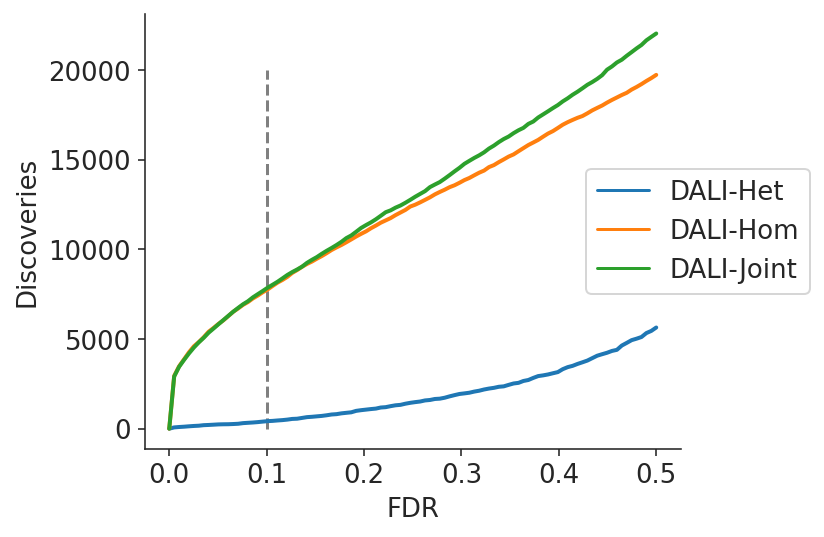

In [18]:
fig, ax = plt.subplots(figsize=(4.8, 4))
sns.lineplot(x='FDR', y='Discoveries', hue='Test', data=discoveries, ax=ax, linewidth=2)
ax.vlines(x=.1, ymin=-10, ymax=20000, linestyle='--', color='grey')
plt.legend(
    loc='center left',
    bbox_to_anchor=(.8, .5))
sns.despine()
save_panel(fig)

In [19]:
peak_highlight = 'chr3R_20310056_20311056'
peak_highlight_exp_id = 'SS159'

peak_highlight_coords = -np.log10(df_all.query('peak == @peak_highlight and cross == @peak_highlight_exp_id')[[DALIHOM_PVAL, DALIHET_PVAL, DALIJOINT_PVAL]])

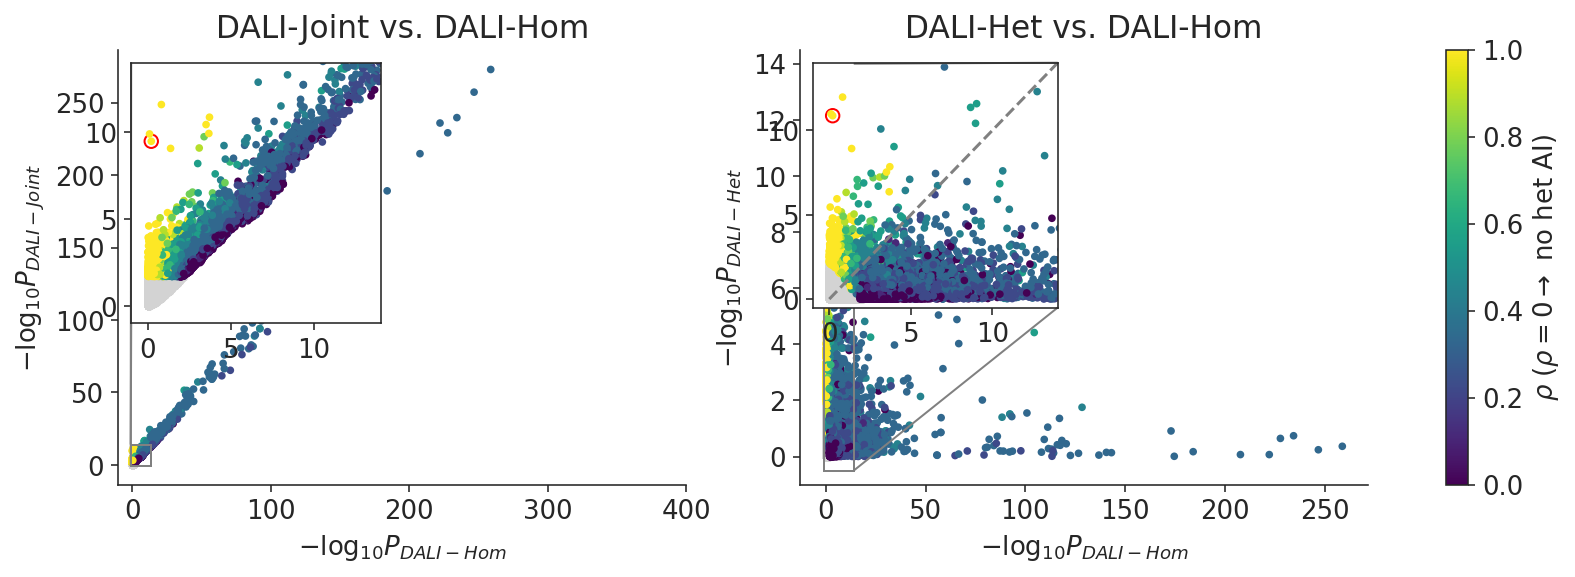

In [20]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes, mark_inset


colors = sns.color_palette(plt.cm.viridis(df_all.query(DALIJOINT_PVAL + '_bh > .1')[DALIJOINT_RHO]), desat=.2, as_cmap=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

ax = axes[0]
ax.scatter(
    -np.log10(df_all.query(DALIJOINT_PVAL + '_bh > .1')[DALIHOM_PVAL]), 
    -np.log10(df_all.query(DALIJOINT_PVAL + '_bh > .1')[DALIJOINT_PVAL]), 
    c='lightgrey',
    rasterized=True,
    s=8)
p=ax.scatter(
    -np.log10(df_all.query(DALIJOINT_PVAL + '_bh < .1')[DALIHOM_PVAL]), 
    -np.log10(df_all.query(DALIJOINT_PVAL + '_bh < .1')[DALIJOINT_PVAL]), 
    c=df_all.query(DALIJOINT_PVAL + '_bh < .1')[DALIJOINT_RHO],
    cmap='viridis',
    rasterized=True,
    s=8)
ax.set(
    xlabel=r'$-\log_{10}P_{DALI-Hom}$',
    ylabel=r'$-\log_{10}P_{DALI-Joint}$',
    title='DALI-Joint vs. DALI-Hom',
    xlim=(-10, 400))

#axins = zoomed_inset_axes(ax, 12, loc='upper left', bbox_to_anchor=(560, 390))
axins = zoomed_inset_axes(ax, 12, loc='upper left')

axins.scatter(
    -np.log10(df_all.query(DALIJOINT_PVAL + '_bh > .1')[DALIHOM_PVAL]), 
    -np.log10(df_all.query(DALIJOINT_PVAL + '_bh > .1')[DALIJOINT_PVAL]), 
    c='lightgrey',
    rasterized=True,
    s=8)
axins.scatter(
    peak_highlight_coords[DALIHOM_PVAL],
    peak_highlight_coords[DALIJOINT_PVAL],
    facecolors='none', edgecolors='r', s=45)
axins.scatter(
    -np.log10(df_all.query(DALIJOINT_PVAL + '_bh < .1')[DALIHOM_PVAL]), 
    -np.log10(df_all.query(DALIJOINT_PVAL + '_bh < .1')[DALIJOINT_PVAL]), 
    c=df_all.query(DALIJOINT_PVAL + '_bh < .1')[DALIJOINT_RHO],
    cmap='viridis',
    rasterized=True,
    s=8)
x1, x2, y1, y2 = -1, 14, -1, 14
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.yaxis.get_major_locator().set_params(nbins=3)
axins.xaxis.get_major_locator().set_params(nbins=3)
mark_inset(ax, axins, loc1=3, loc2=2, fc='none', ec='.5')

ax = axes[1]
ax.scatter(
    -np.log10(df_all.query(DALIJOINT_PVAL + '_bh > .1')[DALIHOM_PVAL]), 
    -np.log10(df_all.query(DALIJOINT_PVAL + '_bh > .1')[DALIHET_PVAL]), 
    c='lightgrey',
    rasterized=True,
    s=8)
p=ax.scatter(
    -np.log10(df_all.query(DALIJOINT_PVAL + '_bh < .1')[DALIHOM_PVAL]), 
    -np.log10(df_all.query(DALIJOINT_PVAL + '_bh < .1')[DALIHET_PVAL]), 
    c=df_all.query(DALIJOINT_PVAL + '_bh < .1')[DALIJOINT_RHO],
    cmap='viridis',
    rasterized=True,
    s=8)
ax.set(
    xlabel=r'$-\log_{10}P_{DALI-Hom}$',
    ylabel=r'$-\log_{10}P_{DALI-Het}$',
    title='DALI-Het vs. DALI-Hom',
    ylim=(-1, 14.5))

#axins = inset_axes(ax, width=1.7, height=1.7, loc='upper left', bbox_to_anchor=(1240, 490))
axins = inset_axes(ax, width=1.7, height=1.7, loc='upper left')

axins.scatter(
    -np.log10(df_all.query(DALIJOINT_PVAL + '_bh > .1')[DALIHOM_PVAL]), 
    -np.log10(df_all.query(DALIJOINT_PVAL + '_bh > .1')[DALIHET_PVAL]), 
    c='lightgrey',
    rasterized=True,
    s=8)
axins.scatter(
    peak_highlight_coords[DALIHOM_PVAL],
    peak_highlight_coords[DALIHET_PVAL],
    facecolors='none', edgecolors='r', s=45)
axins.scatter(
    -np.log10(df_all.query(DALIJOINT_PVAL + '_bh < .1')[DALIHOM_PVAL]), 
    -np.log10(df_all.query(DALIJOINT_PVAL + '_bh < .1')[DALIHET_PVAL]), 
    c=df_all.query(DALIJOINT_PVAL + '_bh < .1')[DALIJOINT_RHO],
    cmap='viridis',
    rasterized=True,
    s=8)
axins.plot([0, 14], [0, 14], linestyle='--', c='grey')

x1, x2, y1, y2 = -1, 14, -.5, 14
# x1, x2, y1, y2 = -1, 14, -.5, 14

axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

axins.yaxis.get_major_locator().set_params(nbins=3)
axins.xaxis.get_major_locator().set_params(nbins=3)
mark_inset(ax, axins, loc1=4, loc2=1, fc='none', ec='.5')


plt.colorbar(p, label=r'$\rho$ ($\rho=0 \rightarrow$ no het AI)', ax=axes)
sns.despine(ax=axes[0])
sns.despine(ax=axes[1])

save_panel(fig)

In [21]:
fdr = .1
X = pd.DataFrame({
    'DALI-Joint': df_all[DALIJOINT_PVAL + '_bh']  < fdr,
    'DALI-Het': df_all[DALIHET_PVAL + '_bh']  < fdr,
    'DALI-Hom': df_all[DALIHOM_PVAL + '_bh']  < fdr
})

/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


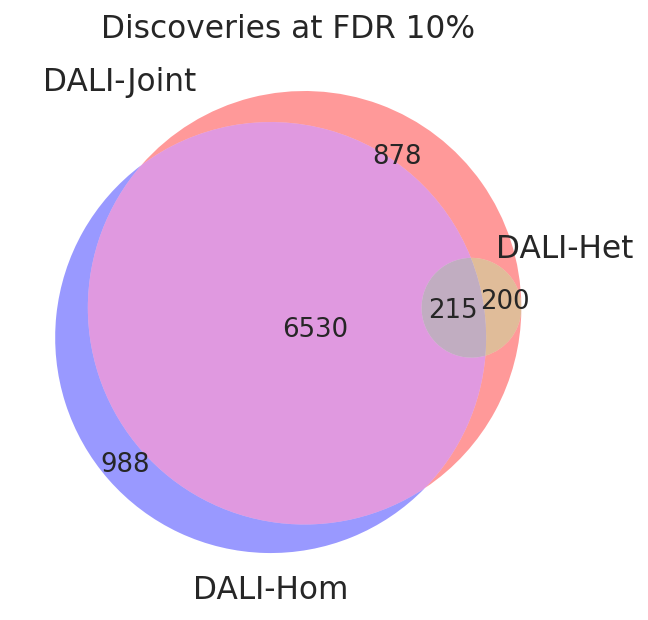

In [22]:
df = X.reset_index().melt(id_vars='index')
df = df[df['value']].groupby('index')['variable'].unique().map(lambda x: '_'.join(x)).value_counts()

X.reset_index().melt(id_vars='index').groupby('index')['variable'].unique()
fig, ax = plt.subplots(figsize=(5, 5))
test_to_int = pd.Series(range(3), index=X.columns)

subsets = dict()
overlaps = df
for overlap in overlaps.index:
    subset_name = np.eye(3, dtype=int)[test_to_int.loc[overlap.split('_')], :].sum(0)
    subset_name = ''.join([str(x) for x in subset_name])
    subsets[subset_name] = overlaps.loc[overlap]
venn.venn3(subsets=subsets, set_labels=test_to_int.index.tolist(), ax=ax)
ax.set_title('Discoveries at FDR 10%')
save_panel(fig)

In [23]:
X.sum(0)

DALI-Joint    7823
DALI-Het       415
DALI-Hom      7733
dtype: int64